In [1]:
import itertools
import os
import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objs as go
import plotly.plotly as py
from sklearn import cluster, manifold, preprocessing

In [2]:
# Set Plotly credentials (should probably use credentials file instead of hard-coding)
plotly.tools.set_credentials_file(username='navravi', api_key='uYbUJOZ3VYmK0YILm3Gq')

In [3]:
# Read in raw data
df_raw = pd.read_csv('compas-scores-two-years.csv',
                     usecols=['age', 'c_charge_degree', 'race', 'score_text',
                              'sex', 'priors_count', 'days_b_screening_arrest',
                              'decile_score', 'is_recid', 'two_year_recid',
                              'c_jail_in', 'c_jail_out', 'c_charge_desc'],
                     parse_dates=['c_jail_in', 'c_jail_out'])

# Filter data
df_raw = df_raw[df_raw['days_b_screening_arrest'] <= 30]
df_raw = df_raw[df_raw['days_b_screening_arrest'] >= -30]
df_raw = df_raw[df_raw['is_recid'] != -1]
df_raw = df_raw[df_raw['c_charge_degree'] != 'O']
df_raw = df_raw[df_raw['score_text'] != 'N/A']

# Calculate time in jail
df_raw.loc[:, 'c_jail_time'] = df_raw['c_jail_out'] - df_raw['c_jail_in']
                
df_raw.head()

,sex,age,race,decile_score,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_charge_degree,c_charge_desc,is_recid,score_text,two_year_recid,c_jail_time
0,Male,69,Other,1,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,F,Aggravated Assault w/Firearm,0,Low,0,0 days 23:37:38
1,Male,34,African-American,3,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,F,Felony Battery w/Prior Convict,1,Low,1,10 days 01:51:26
2,Male,24,African-American,4,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,F,Possession of Cocaine,1,Low,1,1 days 02:03:30
5,Male,44,Other,1,0,0.0,2013-11-30 04:50:18,2013-12-01 12:28:56,M,Battery,0,Low,0,1 days 07:38:38
6,Male,41,Caucasian,6,14,-1.0,2014-02-18 05:08:24,2014-02-24 12:18:30,F,Possession Burglary Tools,1,Medium,1,6 days 07:10:06


In [4]:
# Choose subset of columns for analysis
df = df_raw[['sex', 'age', 'priors_count', 'c_jail_time', 'c_charge_degree',
             'two_year_recid']]
df = df.copy()

# Convert time in jail to seconds
df['c_jail_time'] = df['c_jail_time'].dt.total_seconds()

# Convert sex to numeric value
df['sex'].replace('Female', 0, inplace=True)
df['sex'].replace('Male', 1, inplace=True)

# Convert charge degree to numeric value
df['c_charge_degree'].replace('F', 0, inplace=True)
df['c_charge_degree'].replace('M', 1, inplace=True)

df.head()

,sex,age,priors_count,c_jail_time,c_charge_degree,two_year_recid
0,1,69,0,85058.0,0,0
1,1,34,0,870686.0,0,1
2,1,24,4,93810.0,0,1
5,1,44,0,113918.0,1,0
6,1,41,14,544206.0,0,1


In [5]:
# Scale features so they have zero mean and unit variance
X = preprocessing.scale(df)
X.shape

(6172, 6)

In [6]:
if os.path.exists('X_tsne.pkl'):
    with open('X_tsne.pkl', 'rb') as pklfile:
        X_tsne = pkl.load(pklfile)
else:
    # Embed data in 2 dimensions using t-SNE for visualization
    tsne = manifold.TSNE(random_state=42)
    X_tsne = tsne.fit_transform(X)
    with open('X_tsne.pkl', 'wb') as pklfile:
        pkl.dump(X_tsne, pklfile)

In [7]:
# Divide data into clusters based on Euclidean distance
kmeans = cluster.KMeans(n_clusters=2, random_state=17)
clusters = kmeans.fit_predict(X)

In [8]:
def make_label(row):
    '''Create label for given row of data.'''
    return 'score: {}, crime: {}, race: {}'.format(row['decile_score'],
                                                   row['c_charge_desc'],
                                                   row['race'])

In [9]:
# Visualize clusters
trace = go.Scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], mode='markers',
                   text=df_raw.apply(make_label, axis=1),
                   marker={'color': clusters, 'colorscale': 'Picnic'})
fig = {'data': [trace], 'layout': {'title': 't-SNE Visualization of Clusters'}}
py.iplot(fig, filename='tsne-clusters')

In [10]:
# Visualize COMPAS scores
trace = go.Scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], mode='markers',
                   text=df_raw.apply(make_label, axis=1),
                   marker={'color': df_raw['decile_score'], 'colorscale': 'Viridis'})
fig = {'data': [trace], 'layout': {'title': 't-SNE Visualization of COMPAS Scores'}}
py.iplot(fig, filename='tsne-scores')

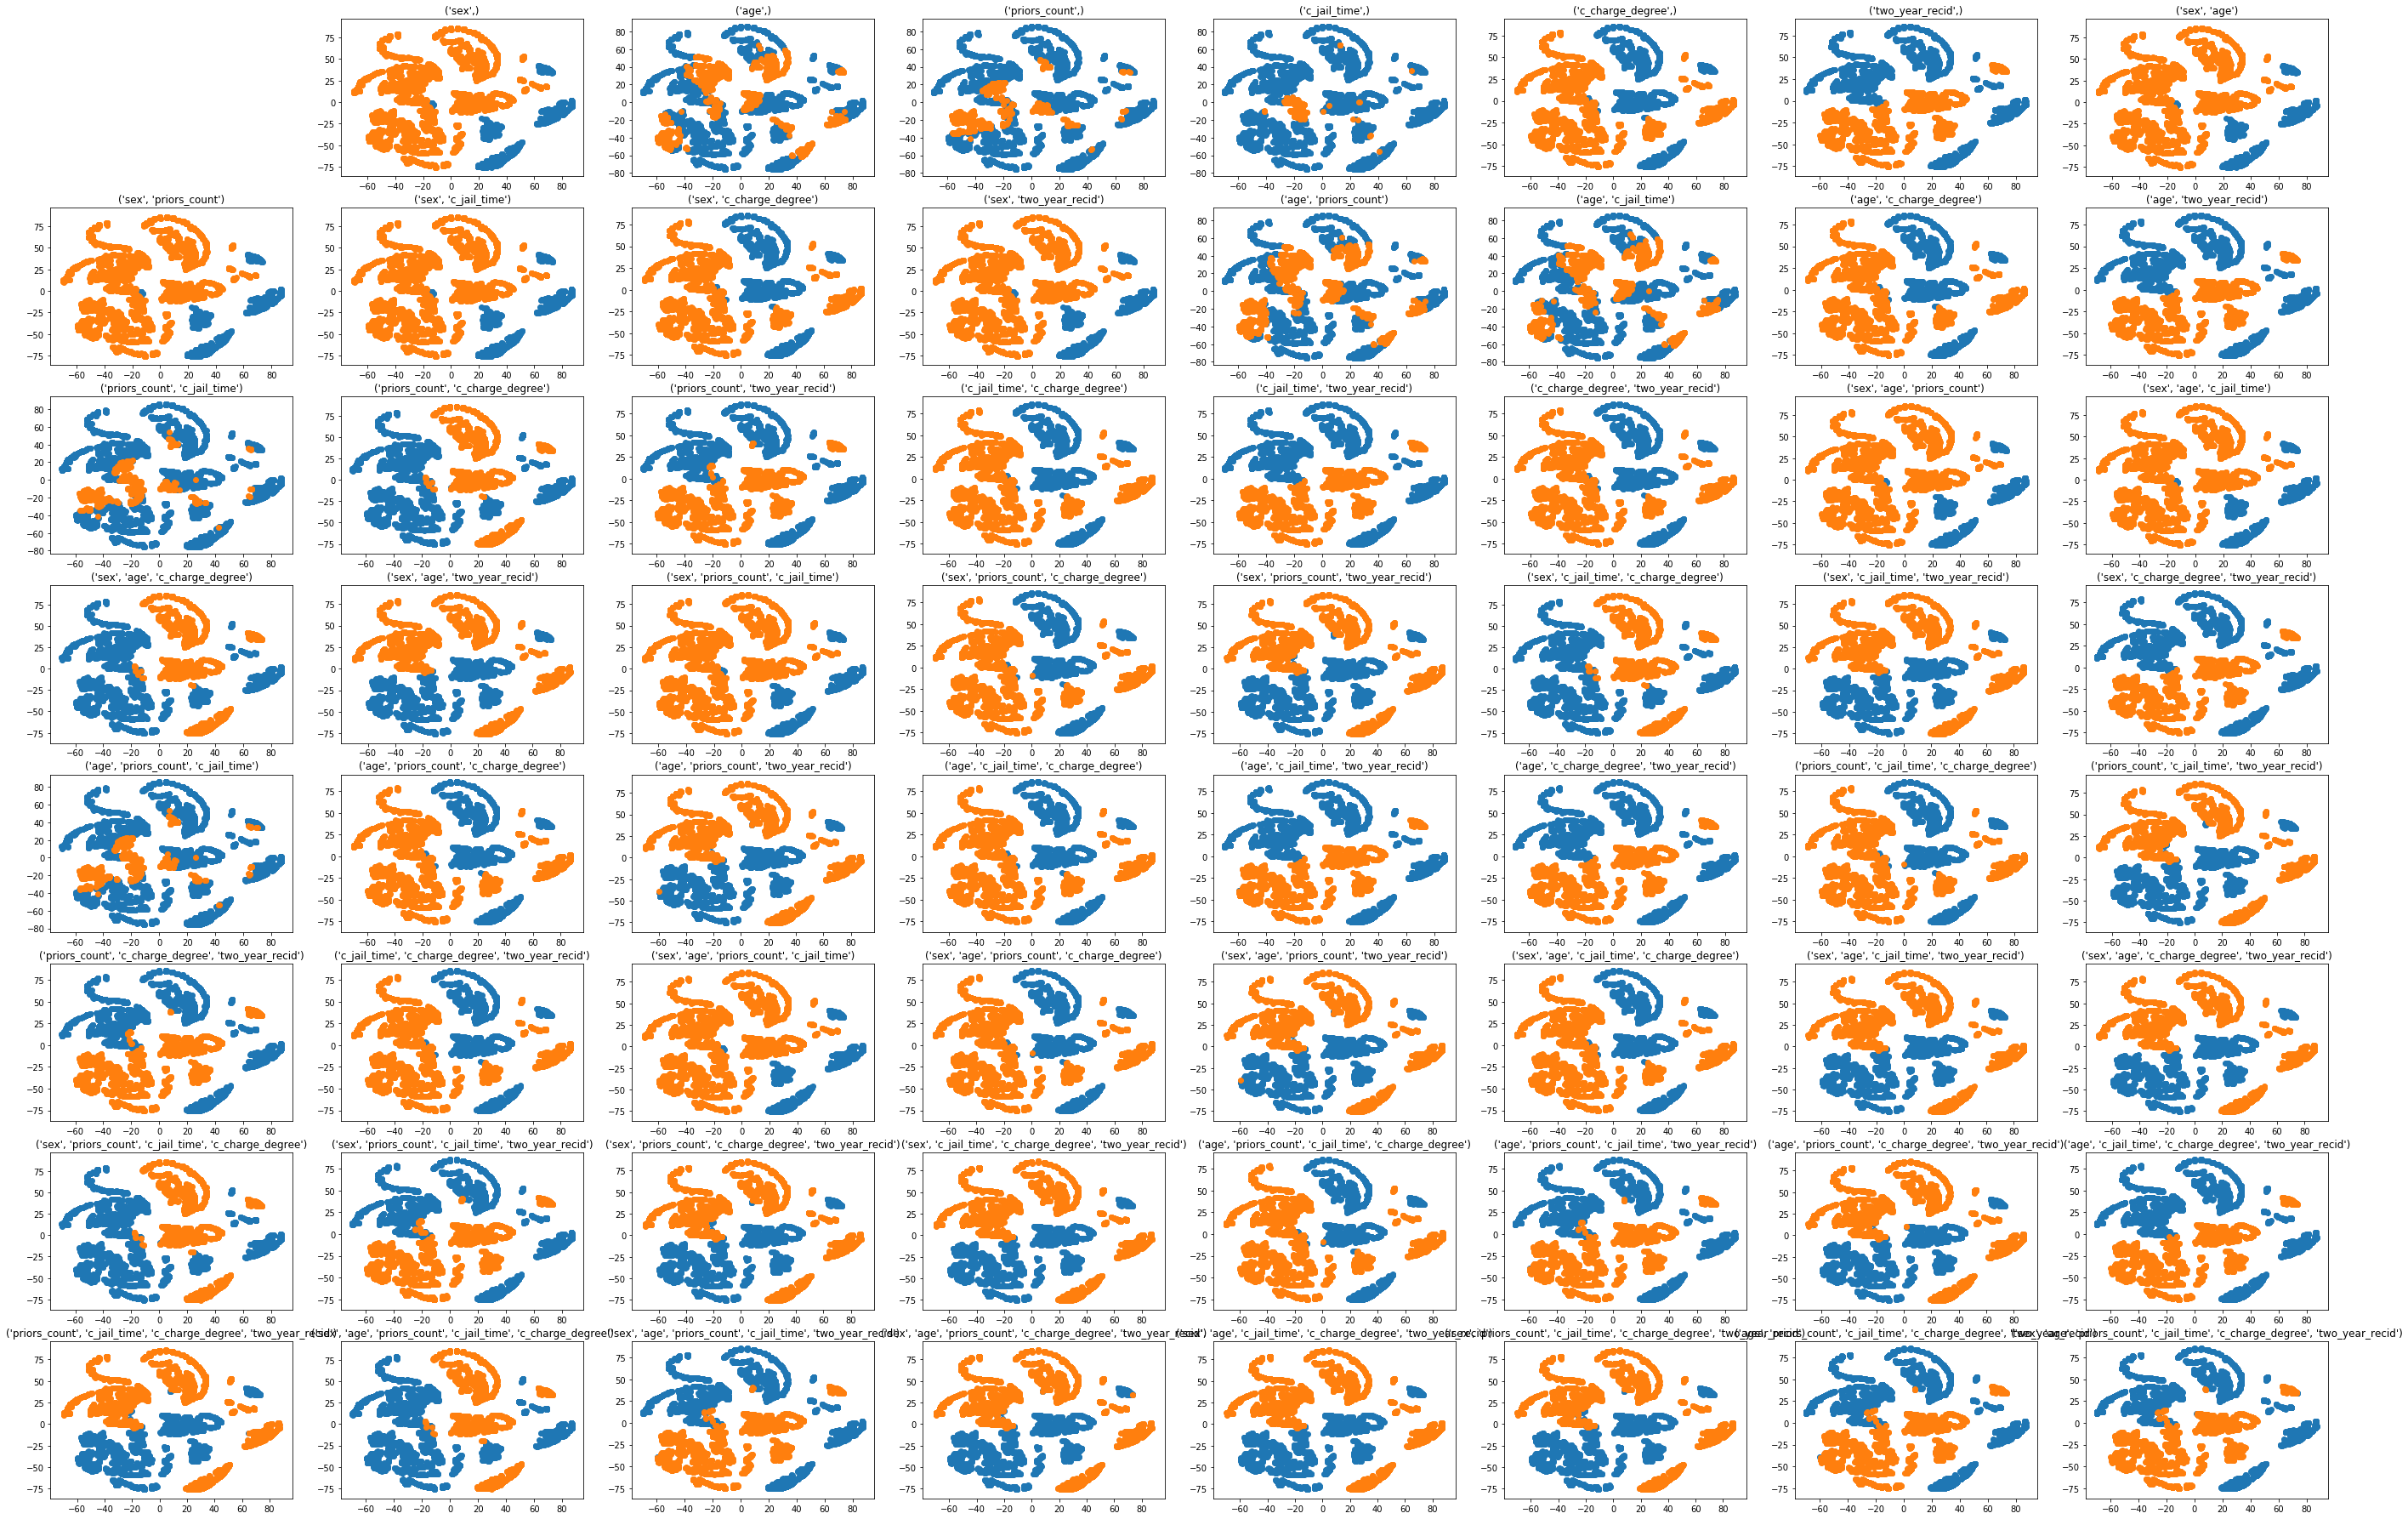

In [11]:
all_cols = ['sex', 'age', 'priors_count', 'c_jail_time', 'c_charge_degree', 'two_year_recid']

fig = plt.figure()
fig.set_figheight(fig.get_figheight() * 8)
fig.set_figwidth(fig.get_figwidth() * 8)

i = 1

for n in range(1, len(all_cols) + 1):
    for cols in itertools.combinations(all_cols, n):
        i += 1
        ax = fig.add_subplot(8, 8, i)
        X = preprocessing.scale(df[list(cols)])
        kmeans = cluster.KMeans(n_clusters=2, random_state=17)
        clusters = kmeans.fit_predict(X)
        ax.scatter(X_tsne[clusters == 0, 0], X_tsne[clusters == 0, 1])
        ax.scatter(X_tsne[clusters == 1, 0], X_tsne[clusters == 1, 1])
        ax.set_title(str(cols))

plt.show()

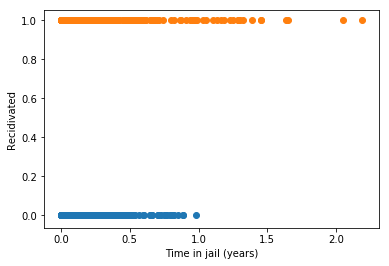

In [12]:
secs_per_year = pd.to_timedelta(1, unit='y').total_seconds()

jail_yrs_norecid = df['c_jail_time'][df_raw['is_recid'] == 0] / secs_per_year
jail_yrs_recid = df['c_jail_time'][df_raw['is_recid'] == 1] / secs_per_year

plt.scatter(jail_yrs_norecid, np.zeros(jail_yrs_norecid.shape))
plt.scatter(jail_yrs_recid, np.ones(jail_yrs_recid.shape))
plt.xlabel('Time in jail (years)')
plt.ylabel('Recidivated')
plt.show()

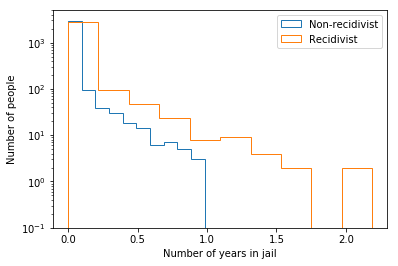

In [13]:
jail_yrs_norecid.hist(histtype='step', log=True, grid=None, label='Non-recidivist')
jail_yrs_recid.hist(histtype='step', log=True, grid=None, label='Recidivist')
plt.xlabel('Number of years in jail')
plt.ylabel('Number of people')
plt.legend()
plt.show()

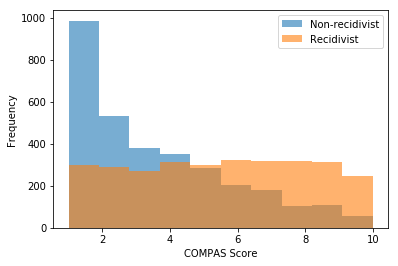

In [14]:
scores_norecid = df_raw['decile_score'][df_raw['is_recid'] == 0]
scores_recid = df_raw['decile_score'][df_raw['is_recid'] == 1]

scores_norecid.hist(grid=None, alpha=0.6, label='Non-recidivist')
scores_recid.hist(grid=None, alpha=0.6, label='Recidivist')
plt.xlabel('COMPAS Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [15]:
all_defendants = pd.DataFrame([[2681, 1282], [1216, 2035]], columns=['Low', 'High'])
black_defendants = pd.DataFrame([[990, 805], [532, 1369]], columns=['Low', 'High'])
white_defendants = pd.DataFrame([[1139, 349], [461, 505]], columns=['Low', 'High'])

In [16]:
def compute_rates(df):
    tp, tn, fp, fn = df.iloc[1, 1], df.iloc[0, 0], df.iloc[0, 1], df.iloc[1, 0]
    return dict(tpr = tp / (tp + fn),
                tnr = tn / (tn + fp),
                ppv = tp / (tp + fp),
                npv = tn / (tn + fn),
                fpr = fp / (fp + tn),
                fnr = fn / (tp + fn),
                acc = (tp + tn) / (tp + fp + fn + tn))

In [17]:
compute_rates(all_defendants)

{'acc': 0.6537288605489326,
 'fnr': 0.3740387573054445,
 'fpr': 0.32349230381024474,
 'npv': 0.6879651013600205,
 'ppv': 0.6135061802833887,
 'tnr': 0.6765076961897553,
 'tpr': 0.6259612426945556}

In [18]:
compute_rates(black_defendants)

{'acc': 0.6382575757575758,
 'fnr': 0.27985270910047344,
 'fpr': 0.44846796657381616,
 'npv': 0.6504599211563732,
 'ppv': 0.6297148114075437,
 'tnr': 0.5515320334261838,
 'tpr': 0.7201472908995266}

In [19]:
compute_rates(white_defendants)

{'acc': 0.6699266503667481,
 'fnr': 0.4772256728778468,
 'fpr': 0.23454301075268819,
 'npv': 0.711875,
 'ppv': 0.5913348946135831,
 'tnr': 0.7654569892473119,
 'tpr': 0.5227743271221532}

In [20]:
def compas_hist(df):
    scores_norecid = df['decile_score'][df['is_recid'] == 0]
    scores_recid = df['decile_score'][df['is_recid'] == 1]

    scores_norecid.hist(grid=None, alpha=0.6, label='Non-recidivist')
    scores_recid.hist(grid=None, alpha=0.6, label='Recidivist')
    plt.xlabel('COMPAS Score')
    plt.ylabel('Frequency')
    plt.ylim([0, 550])
    plt.legend()
    plt.show()

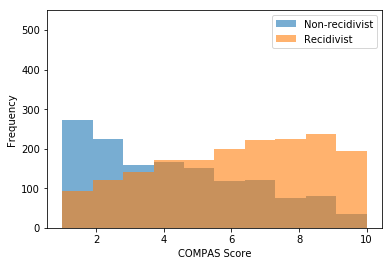

In [21]:
compas_hist(df_raw[df_raw['race'] == 'African-American'])

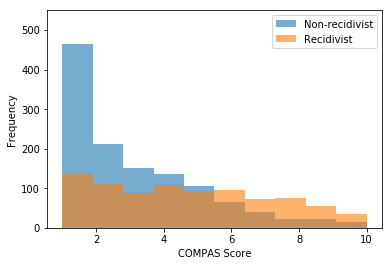

In [22]:
compas_hist(df_raw[df_raw['race'] == 'Caucasian'])

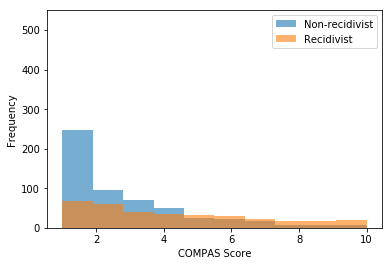

In [23]:
compas_hist(df_raw[np.logical_and(df_raw['race'] != 'African-American', df_raw['race'] != 'Caucasian')])

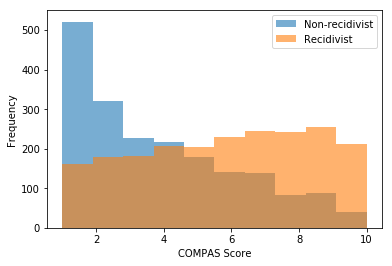

In [24]:
compas_hist(df_raw[df_raw['race'] != 'Caucasian'])

In [25]:
def loss_pwconst(x):
    return 1.0 * (x > 4.5)

def loss_pwlin(x):
    return 0.5/3.5 * (x - 1) * (x < 4.5) + 0.5/5.5 * (x + 1) * (x > 4.5)

def acc(df, loss):
    fp = loss(df['decile_score'][df['is_recid'] == 0])
    fn = 1 - loss(df['decile_score'][df['is_recid'] == 1])
    return 1 - (fp.sum() + fn.sum()) / len(df)

In [26]:
df_all = df_raw[['decile_score', 'is_recid', 'race']]
df_black = df_all[df_all['race'] == 'African-American']
df_white = df_all[df_all['race'] == 'Caucasian']

In [27]:
acc(df_all, loss_pwconst), acc(df_black, loss_pwconst), acc(df_white, loss_pwconst)

(0.6586195722618275, 0.6516535433070867, 0.6623870660960532)

In [28]:
acc(df_all, loss_pwlin), acc(df_black, loss_pwlin), acc(df_white, loss_pwlin)

(0.6217963824898368, 0.612213927804479, 0.6277920842828117)

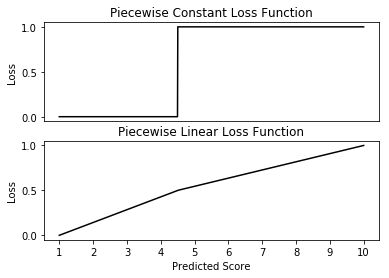

In [29]:
x = np.linspace(1, 10, 1000)

fig = plt.figure()

ax = fig.add_subplot(2, 1, 1)
ax.plot(x, loss_pwconst(x), 'k')
ax.set_xticks([])
ax.set_ylabel('Loss')
ax.set_title('Piecewise Constant Loss Function')

ax = fig.add_subplot(2, 1, 2)
ax.plot(x, loss_pwlin(x), 'k')
ax.set_xticks(np.linspace(1, 10, 10))
ax.set_xlabel('Predicted Score')
ax.set_ylabel('Loss')
ax.set_title('Piecewise Linear Loss Function')

plt.show()